### Demo for simple RAG using knowledge graphs and OCI Generative AI Service

In [1]:
# Import necessary functions and libraries
from search_graph import vector_search_graph, get_next_nodes
from show_graph import show_graph
from config_private import COMPARTMENT_OCID
import oci

In [2]:
# Setup basic variables
# Auth Config
compartment_id = COMPARTMENT_OCID
CONFIG_PROFILE = "DEFAULT"
config = oci.config.from_file('~/.oci/config', CONFIG_PROFILE)

# Service endpoint, Frankfurt or Chicago
endpoint = "https://inference.generativeai.eu-frankfurt-1.oci.oraclecloud.com"

In [3]:
# User query
query = "Who were the founders of Oracle?"
# Get most relevant relations
relations = vector_search_graph(query, top_n=20)

/Users/elmernickels/Documents/JOBB/Graph/.conda/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/Users/elmernickels/Documents/JOBB/Graph/.conda/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/elmernickels/Documents/JOBB/Graph/.conda/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same 

('Oracle Corporation', 'was founded in', '1977')
('Larry Ellison', 'co-founded', 'Oracle Corporation')
('Oracle Corporation', 'headquartered in', 'Austin, Texas')
('Oracle Corporation', 'acquired several companies', 'which formerly functioned autonomously')
('Oracle Corporation', 'is', 'American multinational computer technology company')
('Oracle Corporation', 'developed', 'Oracle Rdb')
('Larry Ellison', 'co-founder of', 'Oracle Corporation')
('Bob Miner', 'co-founder of', 'Oracle Corporation')
('Ed Oates', 'co-founder of', 'Oracle Corporation')
('Oracle Corporation', 'developed', 'Oracle NoSQL Database')
('Oracle Systems Corporation', 'was renamed to', 'Oracle Corporation')
('Oracle Corporation', 'partnered with', 'Microsoft')
('Oracle Corporation', 'had headquarters in', 'Redwood Shores from 1989 to 2020')
('Oracle Corporation', 'was originally named', 'Software Development Laboratories (SDL)')
('Larry Ellison', 'co-founded Oracle Corporation with', 'Bob Miner')
('Oracle Corporation

Example output:
- ('Oracle Corporation', 'was founded in', '1977')
- ('Larry Ellison', 'co-founded', 'Oracle Corporation')
- ('Oracle Corporation', 'headquartered in', 'Austin, Texas')
- ('Oracle Corporation', 'acquired several companies', 'which formerly functioned autonomously')
- ('Oracle Corporation', 'is', 'American multinational computer technology company')
- ('Oracle Corporation', 'developed', 'Oracle Rdb')
- ('Larry Ellison', 'co-founder of', 'Oracle Corporation')
- ('Bob Miner', 'co-founder of', 'Oracle Corporation')
- ('Ed Oates', 'co-founder of', 'Oracle Corporation')
- ('Oracle Corporation', 'developed', 'Oracle NoSQL Database')
- ('Oracle Systems Corporation', 'was renamed to', 'Oracle Corporation')
- ('Oracle Corporation', 'partnered with', 'Microsoft')
- ('Oracle Corporation', 'had headquarters in', 'Redwood Shores from 1989 to 2020')
- ('Oracle Corporation', 'was originally named', 'Software Development Laboratories (SDL)')
- ('Larry Ellison', 'co-founded Oracle Corporation with', 'Bob Miner')
- ('Oracle Corporation', 'acquired', 'BEA Systems')
- ('Larry Ellison', 'co-founded Oracle Corporation with', 'Ed Oates')
- ('Oracle Corporation', 'world headquarters located in', 'Austin, Texas since December 2020')
- ('David Litchfield et al.', 'demonstrated', 'successful attacks against Oracle products')
- ('Oracle Corporation', 'offices located in', 'Markham, Ontario, Canada')

In [4]:
# Show a partial knowledge graph
head, relation, tail = list(zip(*relations))
show_graph(head, relation, tail)

Example output:
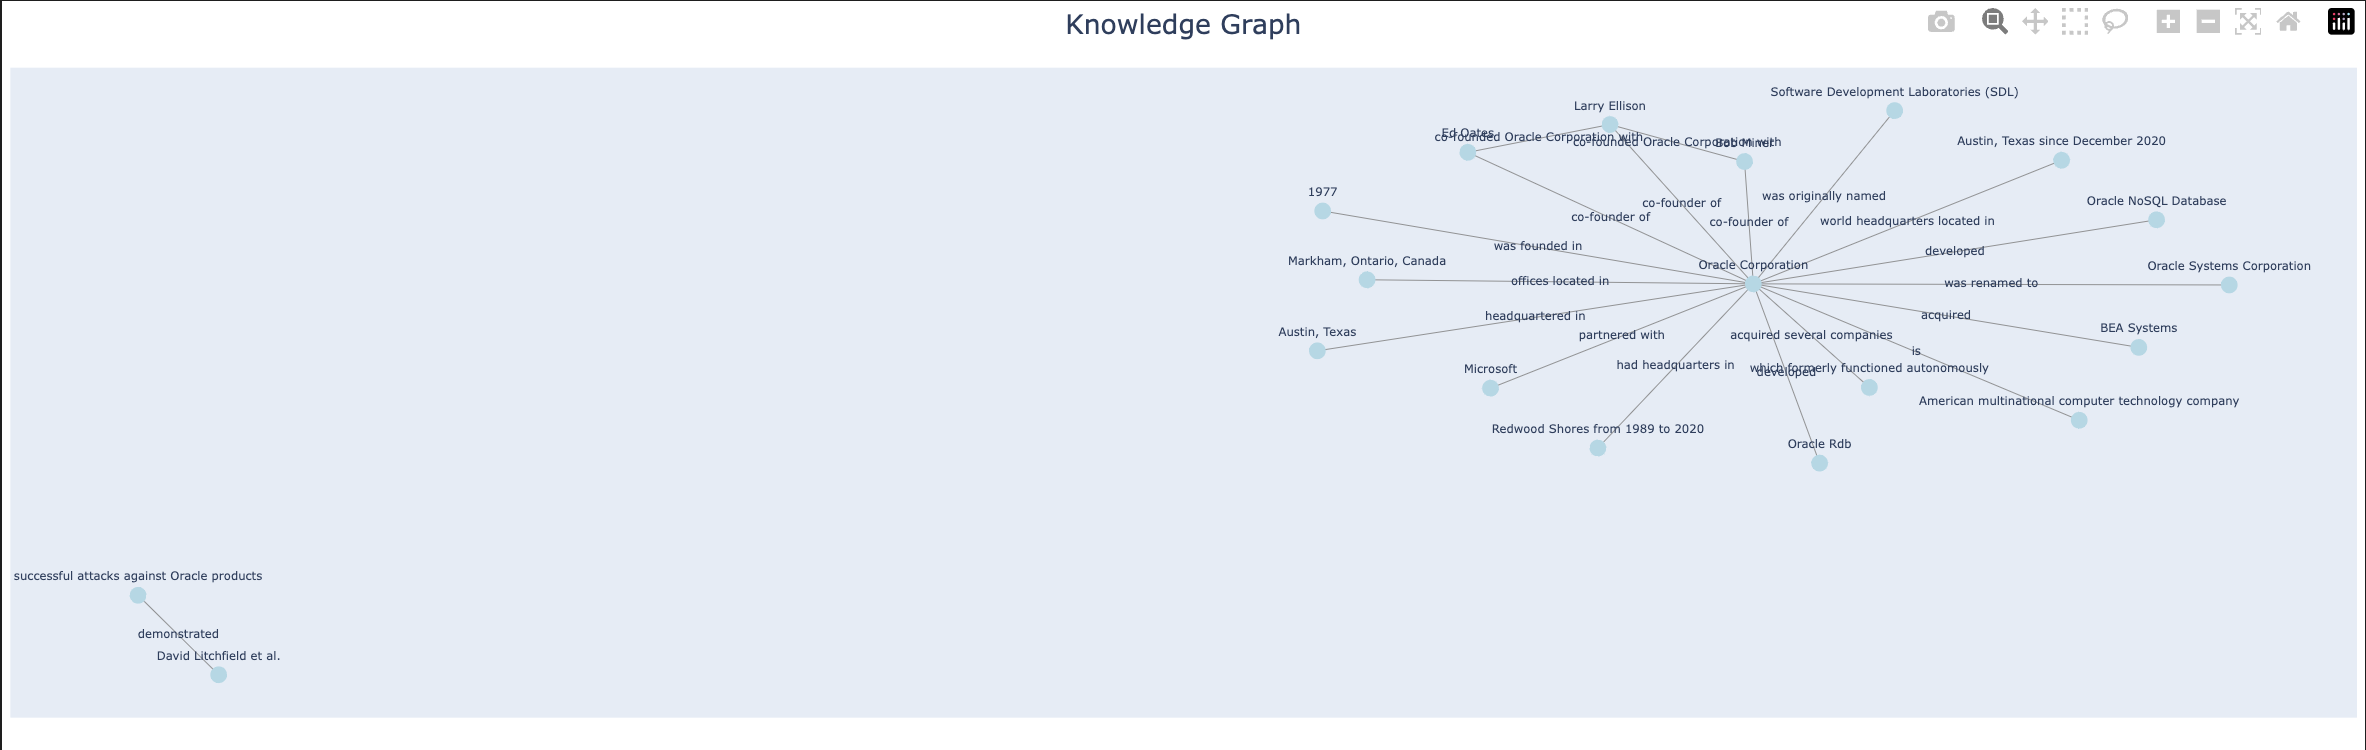

In [5]:
# Define rerank prompt
rerank_prompt = f'''Rerank the following knowledge graph relations based on their relevance to the query. 
            You should include all triplets given as context in your answer. Don't drop any that you feel are irrelevant, just order them last.
            Output only the same relations in the reranked order without any further explanation: 
            QUERY: {query}
            RELATIONS: {relations}'''

In [6]:
# Perform reranking
generative_ai_inference_client = oci.generative_ai_inference.GenerativeAiInferenceClient(config=config, service_endpoint=endpoint, retry_strategy=oci.retry.NoneRetryStrategy(), timeout=(10,240))
rerank_chat_detail = oci.generative_ai_inference.models.ChatDetails()

rerank_chat_request = oci.generative_ai_inference.models.CohereChatRequest()
rerank_chat_request.message = rerank_prompt
rerank_chat_request.max_tokens = 800
rerank_chat_request.temperature = 0.2
rerank_chat_request.frequency_penalty = 0
rerank_chat_request.top_p = 0.75
rerank_chat_request.top_k = 0


rerank_chat_detail.serving_mode = oci.generative_ai_inference.models.OnDemandServingMode(model_id="ocid1.generativeaimodel.oc1.eu-frankfurt-1.amaaaaaask7dceyazi3cpmptwa52f7dgwyskloughcxtjgrqre3pngwtig4q")
rerank_chat_detail.chat_request = rerank_chat_request
rerank_chat_detail.compartment_id = compartment_id
rerank_chat_response = generative_ai_inference_client.chat(rerank_chat_detail)
# Print result
print("**************************Chat Result**************************")
#print(vars(rerank_chat_response))
# Reranked relations
reranked_relations = vars(rerank_chat_response)["data"].chat_response.text
print(reranked_relations)

**************************Chat Result**************************
['Oracle Corporation', 'was founded in', '1977'], ['Larry Ellison', 'co-founded', 'Oracle Corporation'], ['Bob Miner', 'co-founder of', 'Oracle Corporation'], ['Ed Oates', 'co-founder of', 'Oracle Corporation'], ['Oracle Corporation', 'headquartered in', 'Austin, Texas'], ['Oracle Corporation', 'is', 'American multinational computer technology company'], ['Larry Ellison', 'co-founded Oracle Corporation with', 'Bob Miner'], ['Larry Ellison', 'co-founded Oracle Corporation with', 'Ed Oates'], ['Oracle Systems Corporation', 'was renamed to', 'Oracle Corporation'], ['Oracle Corporation', 'developed', 'Oracle Rdb'], ['Oracle Corporation', 'developed', 'Oracle NoSQL Database'], ['Oracle Corporation', 'acquired several companies', 'which formerly functioned autonomously'], ['Oracle Corporation', 'partnered with', 'Microsoft'], ['Oracle Corporation', 'had headquarters in', 'Redwood Shores from 1989 to 2020'], ['Oracle Corporation'

In [7]:
# Get best n after reranking, currently set to 10
# TODO make this a bit smarter 
context_relations = "".join(list(filter(lambda x: len(x) > 1, [i + ']' for i in reranked_relations.split("]")]))[:10])
print(context_relations)

['Oracle Corporation', 'was founded in', '1977'], ['Larry Ellison', 'co-founded', 'Oracle Corporation'], ['Bob Miner', 'co-founder of', 'Oracle Corporation'], ['Ed Oates', 'co-founder of', 'Oracle Corporation'], ['Oracle Corporation', 'headquartered in', 'Austin, Texas'], ['Oracle Corporation', 'is', 'American multinational computer technology company'], ['Larry Ellison', 'co-founded Oracle Corporation with', 'Bob Miner'], ['Larry Ellison', 'co-founded Oracle Corporation with', 'Ed Oates'], ['Oracle Systems Corporation', 'was renamed to', 'Oracle Corporation'], ['Oracle Corporation', 'developed', 'Oracle Rdb']


Example output:
- ['Oracle Corporation', 'was founded in', '1977'], 
- ['Larry Ellison', 'co-founded', 'Oracle Corporation'], 
- ['Bob Miner', 'co-founder of', 'Oracle Corporation'], 
- ['Ed Oates', 'co-founder of', 'Oracle Corporation'], 
- ['Oracle Corporation', 'headquartered in', 'Austin, Texas'], 
- ['Oracle Corporation', 'is', 'American multinational computer technology company'], 
- ['Larry Ellison', 'co-founded Oracle Corporation with', 'Bob Miner'], 
- ['Larry Ellison', 'co-founded Oracle Corporation with', 'Ed Oates'], 
- ['Oracle Systems Corporation', 'was renamed to', 'Oracle Corporation'], 
- ['Oracle Corporation', 'developed', 'Oracle Rdb'], 

In [8]:
# Define RAG prompt
rag_query = f'''You are an assistant for question-answering tasks. Use the following pieces of retrieved context in the form of a partial knowledge graph given in triplets in the order of
        most relevant to least relevant to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
        Question: {query} 
        Context: {context_relations} 
        Answer:'''

In [9]:
# Execute RAG prompt and print response
chat_detail = oci.generative_ai_inference.models.ChatDetails()

chat_request = oci.generative_ai_inference.models.CohereChatRequest()
chat_request.message = rag_query
chat_request.max_tokens = 800
chat_request.temperature = 0.3
chat_request.frequency_penalty = 0
chat_request.top_p = 0.75
chat_request.top_k = 0


chat_detail.serving_mode = oci.generative_ai_inference.models.OnDemandServingMode(model_id="ocid1.generativeaimodel.oc1.eu-frankfurt-1.amaaaaaask7dceyazi3cpmptwa52f7dgwyskloughcxtjgrqre3pngwtig4q")
chat_detail.chat_request = chat_request
chat_detail.compartment_id = compartment_id
chat_response = generative_ai_inference_client.chat(chat_detail)
# Print result
print("**************************Chat Result**************************")
print(vars(chat_response))

**************************Chat Result**************************
{'status': 200, 'headers': {'content-type': 'application/json', 'opc-request-id': '2EFE51891C594B40B203021D076C9384/D3D2568A9B8CD8B09D7678A3B023938A/F0761F3A740E36F7C24F042CEAC2E4F0', 'content-encoding': 'gzip', 'content-length': '676'}, 'data': {
  "chat_response": {
    "api_format": "COHERE",
    "chat_history": [
      {
        "message": "You are an assistant for question-answering tasks. Use the following pieces of retrieved context in the form of a partial knowledge graph given in triplets in the order of\n        most relevant to least relevant to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\n        Question: Who were the founders of Oracle? \n        Context: ['Oracle Corporation', 'was founded in', '1977'], ['Larry Ellison', 'co-founded', 'Oracle Corporation'], ['Bob Miner', 'co-founder of', 'Oracle Corporation'], ['Ed 

Example output:
- "Oracle Corporation was founded in 1977 by Larry Ellison, Bob Miner, and Ed Oates."

Which is correct :-)